<a href="https://colab.research.google.com/github/harikrishnanr96/TravelRAGChatBot/blob/main/Evaluation_of_rags_using_RAGAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install langchain_community \
              langchain \
              langchain_openai \
              ragas\
              langchain_huggingface\
              sentence_transformers\
              ctransformers\
              pypdf\
              faiss-gpu\
              datasets\
              transformers\
              sentence-transformers\
              openai\
              unstructured[pdf]\
              rank_bm25

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 38.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of unstructured[pdf] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 k

In [ ]:
import pandas as pd
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import OllamaEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
import os
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader,CSVLoader,DirectoryLoader,TextLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.llms import CTransformers
from langchain.retrievers import BM25Retriever
import openai
from google.colab import userdata

LOADING THE DOCUMENTS

In [ ]:
loader = DirectoryLoader("/content/drive/MyDrive/app/data")
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=20)
documents = loader.load_and_split(text_splitter)

In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPEN_AI_API_KEY')

'sk-proj-CODKcRCaeWWQCV0MqN5sT3BlbkFJWboX7KUB4rHp0LU20JO2'

GENERATING TEST DATA SET USING RAGAS


In [ ]:
generator_llm = ChatOpenAI(model="gpt-3.5-turbo-16k")
critic_llm = ChatOpenAI(model="gpt-4")
embeddings = OpenAIEmbeddings()


In [ ]:
generator = TestsetGenerator.from_langchain(
    generator_llm=generator_llm,
    critic_llm=critic_llm,A
    embeddings=embeddings
)

testset = generator\.generate_with_langchain_docs(documents, test_size=10, \
                               distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25}, raise_exceptions=False)

In [ ]:
test_df = testset.to_pandas()
test_df.head()

In [ ]:
test_df.to_csv('test_data_openai.csv')

GENERATING VECTOR EMBEDDINGS AND STORING IT INTO FAISS VECTOR STORE

In [ ]:
DB_FAISS_PATH ="/content/drive/MyDrive/app/vectorstores/db_faiss"

def create_vector_db():
    csv_loader =CSVLoader(file_path= "/content/drive/MyDrive/app/data/london_travel_data.csv",encoding="utf-8",csv_args={'delimiter':',',
                                                                      "fieldnames": ["Section", "Subsection", "Content"]})
    csv_documents = csv_loader.load()

    pdf_loader = DirectoryLoader('/content/drive/MyDrive/app/data/', glob = "**/*.pdf",show_progress=True,loader_cls=PyPDFLoader)

    pdf_documents  = pdf_loader.load()

    text_loader = DirectoryLoader("/content/drive/MyDrive/app/data/",glob="**/*.txt",loader_cls=TextLoader)

    text_documents = text_loader.load()

    loaded_documents = csv_documents + text_documents + pdf_documents

    text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500,chunk_overlap = 50)
    texts = text_splitter.split_documents(loaded_documents)

    embeddings = HuggingFaceEmbeddings(model_name = 'sentence-transformers/all-MiniLM-L6-v2',
                                       model_kwargs = {'device':'cpu'})

    db = FAISS.from_documents(texts,embeddings)
    db.save_local(DB_FAISS_PATH)

create_vector_db()



100%|██████████| 6/6 [00:21<00:00,  3.55s/it]


Loading THE Large Language Model

In [ ]:

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_llm(model_name,model_type):
    config = {'max_new_tokens': 1024, 'repetition_penalty': 1.1, 'context_length': 8000, 'temperature':0.5}
    llm = CTransformers( model = model_name,
    model_type = model_type,
    config = config)
    return llm


Defining the custom Prompt Template

In [ ]:
custom_prompt_template = """ Use the following
 pieces of information to answer the user's question.
 If you don't know the answer, don't try to make up an answer.

 Context:{context}
 Question:{question}

 Only returns the helpful answer below and nothing else.
 Helpful answer:
 """

Retrieval Module

In [ ]:
from langchain.chains import RetrievalQA
from langchain import PromptTemplate
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

def qa_bot(llm):
    embeddings = HuggingFaceEmbeddings(model_name = 'sentence-transformers/all-MiniLM-L6-v2',
                                          model_kwargs = {'device':device})
    db = FAISS.load_local("/content/drive/MyDrive/app/vectorstores/db_faiss",embeddings,allow_dangerous_deserialization=True)

    prompt = PromptTemplate(template = custom_prompt_template,
                                input_variables=['context','question'])

    qa_chain = RetrievalQA.from_chain_type(
        llm = llm,
        chain_type = 'stuff',
        retriever = db.as_retriever(search_kwargs = {'k':2}),
        return_source_documents = True,
        chain_type_kwargs = {'prompt':prompt}
      )

    return qa_chain

Evaluation for Llama-2-7b

In [ ]:

import os
import openai

import pandas as pd

configs = {"model":"TheBloke/Llama-2-7B-Chat-GGML",
          "model_type":"llama"}

os.environ['OPENAI_API_KEY'] = "sk-proj-CODKcRCaeWWQCV0MqN5sT3BlbkFJWboX7KUB4rHp0LU20JO2"
openai.api_key = os.environ['OPENAI_API_KEY']

df = pd.read_csv('/content/drive/MyDrive/app/test_data_rgs.csv')
questions = df["question"].to_list()
ground_truth = df["ground_truth"].to_list()

llm = load_llm(configs["model"],configs["model_type"])
qa_chain = qa_bot(llm)

results = []
contexts_glob = []
for query in questions:
    result = qa_chain({"query":query})
    results.append(result["result"])
    sources = result["source_documents"]
    content = []
    for i in range(len(sources)):
      content.append(sources[i].page_content)
    contexts_glob.append(content)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

llama-2-7b-chat.ggmlv3.q2_K.bin:   0%|          | 0.00/2.87G [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  warn_deprecated(


Evaluating Llama-2-7b Results **using** RAGAS

> Add blockquote



In [ ]:
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_similarity, answer_correctness
from ragas.metrics.critique import harmfulness
from ragas import evaluate
from datasets import Dataset
d_llama= {
    "question":questions,
    "answer":results,
    "contexts":contexts_glob,
    "ground_truth":ground_truth
}

dataset = Dataset.from_dict(d_llama)

score_llama = evaluate(dataset,metrics=[faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_similarity, answer_correctness, harmfulness])

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
score_llama_df = score_llama.to_pandas()
score_llama_df.head()

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_precision,context_recall,context_entity_recall,answer_similarity,answer_correctness,harmfulness
0,What is the location of the Whitechapel statio...,The Whitechapel station is located near Liver...,[Source: TfL Public Transport Service Planning...,Whitechapel station is located in the tunnelle...,0.000000,0.957738,0.0,0.000000,0.200000,0.891154,0.522788,0
1,What is a hostess fee and how does it relate t...,A hostess fee is an additional charge that ma...,[an atm and stand over them while they extract...,A hostess fee is a charge that appears on the ...,0.307692,0.932616,1.0,0.666667,0.600000,0.957670,0.828703,0
2,What are some options for high-end fine dining...,1. Halko\n2. Itsu\n3. Yakamai,[Content: due to the mix of cultures and relig...,Royal China is an excellent option for high-en...,0.000000,0.869178,0.0,0.000000,0.333333,0.710630,0.177650,0
3,What is the methodology used for counting peop...,1. The methodology used for counting people wi...,[only board and alight buses at designated bus...,The inner cordon surrounding the Olympic Park ...,0.400000,0.996278,1.0,0.000000,0.000000,0.844154,0.787962,0
4,Where can one find cheap eats in London?,"For a truly budget-friendly option, try the ""...",[Content: for suggestions of specific restaura...,Good Indian/Bangladeshi options can be found i...,0.000000,0.931837,0.5,1.000000,0.000000,0.806064,0.201516,1


In [ ]:
score_llama_df.to_csv("EvaluationScoresLlama2new.csv",encoding="utf-8",index=False)

Evaluation For Mistral Using RAGAS

In [ ]:
configs = {"model":"TheBloke/Mistral-7B-Instruct-v0.1-GGUF",
          "model_type":"mistral"}

openai.api_key = os.environ['OPENAI_API_KEY']

df = pd.read_csv('/content/drive/MyDrive/app/test_data_rgs.csv')
questions = df["question"].to_list()
ground_truth = df["ground_truth"].to_list()

llm = load_llm(configs["model"],configs["model_type"])
qa_chain = qa_bot(llm)

results = []
contexts = []
for query in questions:
    result = qa_chain({"query":query})
    results.append(result["result"])
    sources = result["source_documents"]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

mistral-7b-instruct-v0.1.Q2_K.gguf:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

In [ ]:
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_similarity, answer_correctness
from ragas.metrics.critique import harmfulness
from ragas import evaluate
from datasets import Dataset
d_mistral = {
    "question":questions,
    "answer":results,
    "contexts":contexts_glob,
    "ground_truth":ground_truth
}

dataset = Dataset.from_dict(d_mistral)

score_mistral = evaluate(dataset,metrics=[faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_similarity, answer_correctness, harmfulness])



Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
score_df_mistral = score_mistral.to_pandas()
score_df_mistral

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_precision,context_recall,context_entity_recall,answer_similarity,answer_correctness,harmfulness
0,What is the location of the Whitechapel statio...,\nThe Whitechapel station on the Elizabeth lin...,[Source: TfL Public Transport Service Planning...,Whitechapel station is located in the tunnelle...,0.000000,0.991697,0.0,0.000000,0.200000,0.939259,0.609815,0
1,What is a hostess fee and how does it relate t...,\n A hostess fee is a charge that may be added...,[an atm and stand over them while they extract...,A hostess fee is a charge that appears on the ...,0.428571,0.973762,1.0,0.666667,0.600000,0.950986,0.468516,0
2,What are some options for high-end fine dining...,"\n For high-end fine dining, dim sum is a popu...",[Content: due to the mix of cultures and relig...,Royal China is an excellent option for high-en...,0.444444,0.947525,0.0,0.000000,0.333333,0.855350,0.213837,1
3,What is the methodology used for counting peop...,\n The methodology used for counting people wi...,[only board and alight buses at designated bus...,The inner cordon surrounding the Olympic Park ...,0.166667,0.996278,1.0,0.000000,0.000000,0.856346,0.214086,0
4,Where can one find cheap eats in London?,\n There are many places to eat cheaply in Lon...,[Content: for suggestions of specific restaura...,Good Indian/Bangladeshi options can be found i...,0.800000,0.950321,0.5,0.000000,0.000000,0.855796,0.513949,0
5,What factors affect the accuracy of tram passe...,\n The accuracy of tram passenger kilometre es...,[2: See note 2 on table 1. \n3: Methodological...,The accuracy of tram passenger kilometre estim...,0.428571,0.954575,1.0,0.600000,0.500000,0.988054,0.747011,0
6,What was the % increase in the Asian populatio...,"\nAccording to Figure 12, the percentage point...",[Travel in London 2023 21Figure 12 Change in p...,The % increase in the Asian population of Lond...,0.500000,0.989431,0.0,1.000000,0.750000,0.884983,0.221257,1
7,When do most weekday journeys on the Elizabeth...,\nMost weekday journeys on the Elizabeth line ...,[Journeys\nJourney time (minutes)Before the El...,Most weekday journeys on the Elizabeth line oc...,0.000000,1.000000,0.5,0.000000,0.333333,0.969095,0.617274,0
8,What is the change in private vehicle volumes ...,\n The reduction in private vehicle trips in L...,"[reduction of 25 per cent. For context, across...",There has been an overall increase in the numb...,0.000000,0.876843,0.0,0.500000,0.400000,0.863100,0.715775,0


In [ ]:
score_df_mistral.to_csv("EvaluationScoresmistralnew.csv",encoding="utf-8",index=False)

Evaluating GPT Using RAGAS

In [ ]:
openai.api_key = os.environ['OPENAI_API_KEY']

df = pd.read_csv('/content/drive/MyDrive/app/test_data_rgs.csv')
questions = df["question"].to_list()
ground_truth = df["ground_truth"].to_list()

embeddings = HuggingFaceEmbeddings(model_name = 'sentence-transformers/all-MiniLM-L6-v2',
                                      model_kwargs = {'device':device})
db = FAISS.load_local("/content/drive/MyDrive/app/vectorstores/db_faiss",embeddings,allow_dangerous_deserialization=True)

prompt = PromptTemplate(template = custom_prompt_template,
                            input_variables=['context','question'])

qa_chain = RetrievalQA.from_chain_type(
    llm = ChatOpenAI(model_name="gpt-3.5-turbo-16k",temperature=0.5),
    chain_type = 'stuff',
    retriever = db.as_retriever(search_kwargs = {'k':2}),
    return_source_documents = True,
    chain_type_kwargs = {'prompt':prompt}
)

results = []
contexts = []
for query in questions:
    result = qa_chain({"query":query})
    results.append(result["result"])
    sources = result["source_documents"]
    content = []

In [ ]:
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_similarity, answer_correctness
from ragas.metrics.critique import harmfulness
from ragas import evaluate
from datasets import Dataset
d_gpt= {
    "question":questions,
    "answer":results,
    "contexts":contexts_glob,
    "ground_truth":ground_truth
}

dataset = Dataset.from_dict(d_gpt)

score_gpt = evaluate(dataset,metrics=[faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_similarity, answer_correctness, harmfulness])



Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
score_df_gpt = score_gpt.to_pandas()
score_df_gpt

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_precision,context_recall,context_entity_recall,answer_similarity,answer_correctness,harmfulness
0,What is the location of the Whitechapel statio...,The Whitechapel station is located on the Eliz...,[Source: TfL Public Transport Service Planning...,Whitechapel station is located in the tunnelle...,0.000000,0.957738,0.0,0.000000,0.200000,0.944174,0.536043,0
1,What is a hostess fee and how does it relate t...,A hostess fee is a charge that appears on the ...,[an atm and stand over them while they extract...,A hostess fee is a charge that appears on the ...,0.875000,0.973762,1.0,0.666667,0.600000,0.990517,0.997630,0
2,What are some options for high-end fine dining...,Some options for high-end fine dining in Londo...,[Content: due to the mix of cultures and relig...,Royal China is an excellent option for high-en...,0.500000,1.000000,0.0,0.000000,0.333333,0.896468,0.224055,0
3,What is the methodology used for counting peop...,The methodology used for counting people withi...,[only board and alight buses at designated bus...,The inner cordon surrounding the Olympic Park ...,1.000000,0.000000,1.0,0.000000,0.000000,0.812254,0.203069,0
4,Where can one find cheap eats in London?,One can find cheap eats in London by exploring...,[Content: for suggestions of specific restaura...,Good Indian/Bangladeshi options can be found i...,1.000000,0.943049,0.5,0.000000,0.000000,0.855413,0.513853,0
5,What factors affect the accuracy of tram passe...,The accuracy of tram passenger kilometre estim...,[2: See note 2 on table 1. \n3: Methodological...,The accuracy of tram passenger kilometre estim...,0.500000,0.954575,1.0,0.600000,0.500000,0.985421,0.621358,0
6,What was the % increase in the Asian populatio...,The information provided does not include the ...,[Travel in London 2023 21Figure 12 Change in p...,The % increase in the Asian population of Lond...,1.000000,0.000000,0.0,1.000000,0.750000,0.924706,0.231177,0
7,When do most weekday journeys on the Elizabeth...,Most weekday journeys on the Elizabeth line oc...,[Journeys\nJourney time (minutes)Before the El...,Most weekday journeys on the Elizabeth line oc...,0.000000,0.999999,0.5,0.000000,0.333333,0.911101,0.227775,0
8,What is the change in private vehicle volumes ...,The change in private vehicle volumes from 201...,"[reduction of 25 per cent. For context, across...",There has been an overall increase in the numb...,0.666667,0.000000,0.0,0.500000,0.400000,0.928164,0.446332,0


In [ ]:
score_df_gpt.to_csv("EvaluationScoresgptnew.csv",encoding="utf-8",index=False)

In [ ]:
score_df_gpt = pd.read_csv('/content/EvaluationScoresgptnew.csv')
score_df_mistral = pd.read_csv('/content/EvaluationScoresmistralnew.csv')
score_llama_df = pd.read_csv('/content/EvaluationScoresLlama2new.csv')



score_df_gpt = score_df_gpt.rename(columns= lambda col: col + '_gpt' if col not in ['question', 'ground_truth'] else col)
score_df_mistral = score_df_mistral.rename(columns= lambda col: col + '_mistral' if col not in ['question', 'ground_truth'] else col)
score_llama_df = score_llama_df.rename(columns= lambda col: col + '_llama' if col not in ['question', 'ground_truth'] else col)

In [ ]:
score_df_gpt.head()

,question,answer_gpt,contexts_gpt,ground_truth,faithfulness_gpt,answer_relevancy_gpt,context_precision_gpt,context_recall_gpt,context_entity_recall_gpt,answer_similarity_gpt,answer_correctness_gpt,harmfulness_gpt
0,What is the location of the Whitechapel statio...,Whitechapel station is located on the Elizabet...,"[""Source: TfL Public Transport Service Plannin...",Whitechapel station is located in the tunnelle...,0.000000,0.955483,1.0,0.000000,0.2,0.952125,0.238021,0
1,What is a hostess fee and how does it relate t...,A hostess fee is a charge that appears on the ...,['an atm and stand over them while they extrac...,A hostess fee is a charge that appears on the ...,0.500000,0.889767,1.0,0.666667,0.5,0.982962,0.382109,0
2,What are some options for high-end fine dining...,"For high-end fine dining in London, you can co...",['Content: due to the mix of cultures and reli...,Royal China is an excellent option for high-en...,1.000000,0.962808,0.0,0.000000,0.5,0.909155,0.227289,0
3,What is the methodology used for counting peop...,The methodology used for counting people withi...,['only board and alight buses at designated bu...,The inner cordon surrounding the Olympic Park ...,0.666667,0.990472,1.0,1.000000,0.0,0.872427,0.218113,0
4,Where can one find cheap eats in London?,For suggestions on affordable dining options i...,['Content: for suggestions of specific restaur...,Good Indian/Bangladeshi options can be found i...,0.666667,0.934823,1.0,0.000000,0.0,0.857844,0.214461,0


In [ ]:
merged_df = score_llama_df.merge(score_df_mistral, on=['question','ground_truth'])
merged_df = merged_df.merge(score_df_gpt, on=['question','ground_truth'])

In [ ]:
merged_df.head()

,question,answer_llama,contexts_llama,ground_truth,faithfulness_llama,answer_relevancy_llama,context_precision_llama,context_recall_llama,context_entity_recall_llama,answer_similarity_llama,...,answer_gpt,contexts_gpt,faithfulness_gpt,answer_relevancy_gpt,context_precision_gpt,context_recall_gpt,context_entity_recall_gpt,answer_similarity_gpt,answer_correctness_gpt,harmfulness_gpt
0,What is the location of the Whitechapel statio...,The Whitechapel station is located near Aldga...,"[""Source: TfL Public Transport Service Plannin...",Whitechapel station is located in the tunnelle...,0.00,0.931955,1,0.000000,0.2,0.910042,...,Whitechapel station is located on the Elizabet...,"[""Source: TfL Public Transport Service Plannin...",0.000000,0.955483,1.0,0.000000,0.2,0.952125,0.238021,0
1,What is a hostess fee and how does it relate t...,A hostess fee is an additional charge that ma...,['an atm and stand over them while they extrac...,A hostess fee is a charge that appears on the ...,0.25,0.955402,1,0.666667,0.5,0.916647,...,A hostess fee is a charge that appears on the ...,['an atm and stand over them while they extrac...,0.500000,0.889767,1.0,0.666667,0.5,0.982962,0.382109,0
2,What are some options for high-end fine dining...,There are many high-end fine dining restauran...,['Content: due to the mix of cultures and reli...,Royal China is an excellent option for high-en...,0.00,0.968533,0,0.000000,0.5,0.857831,...,"For high-end fine dining in London, you can co...",['Content: due to the mix of cultures and reli...,1.000000,0.962808,0.0,0.000000,0.5,0.909155,0.227289,0
3,What is the methodology used for counting peop...,The methodology used for counting people with...,['only board and alight buses at designated bu...,The inner cordon surrounding the Olympic Park ...,0.00,0.990472,1,1.000000,0.0,0.817115,...,The methodology used for counting people withi...,['only board and alight buses at designated bu...,0.666667,0.990472,1.0,1.000000,0.0,0.872427,0.218113,0
4,Where can one find cheap eats in London?,1. The area of Camden is a good place to look ...,['Content: for suggestions of specific restaur...,Good Indian/Bangladeshi options can be found i...,0.50,0.981683,1,1.000000,0.0,0.852555,...,For suggestions on affordable dining options i...,['Content: for suggestions of specific restaur...,0.666667,0.934823,1.0,0.000000,0.0,0.857844,0.214461,0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt



metrics =  ['faithfulness','answer_relevancy', 'context_precision', 'context_recall',
       'context_entity_recall', 'answer_similarity', 'answer_correctness',
       'harmfulness']

data = []
for metric in metrics:
    llama_scores = merged_df[f'{metric}_llama'].mean()  # Or another aggregation function like median
    mistral_scores = merged_df[f'{metric}_mistral'].mean()
    gpt_scores = merged_df[f'{metric}_gpt'].mean()
    data.append([llama_scores, mistral_scores, gpt_scores])

# Convert to DataFrame for heatmap
heatmap_df = pd.DataFrame(data, index=metrics, columns=['Llama', 'Mistral', 'GPT'])

# Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', linewidths=.5)
# plt.title('Heatmap of Model Scores by Metric')
# plt.xlabel('Models')
# plt.ylabel('Metrics')
# plt.show()


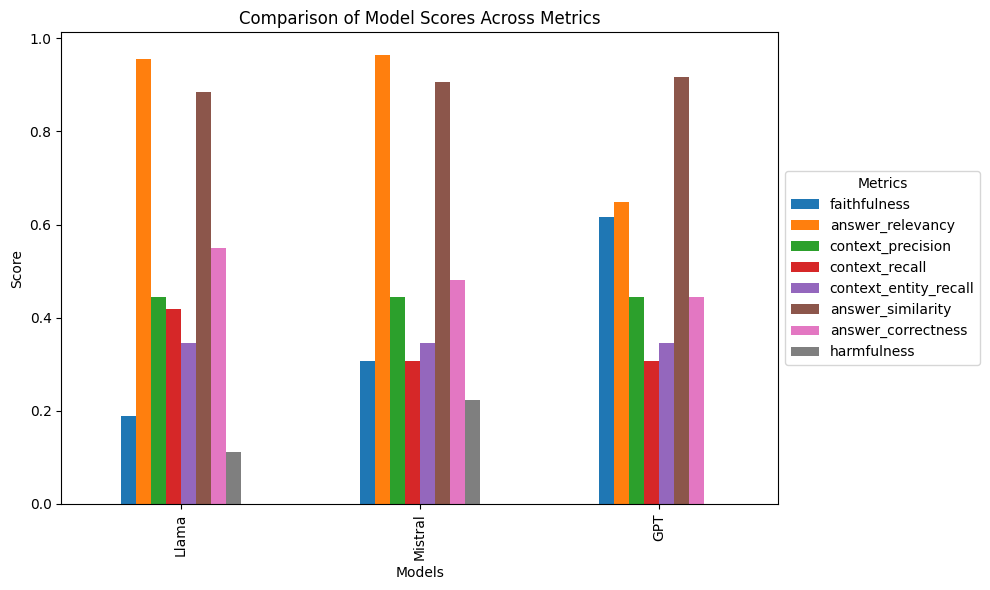

In [ ]:
df = pd.DataFrame(data, index=metrics, columns=['Llama', 'Mistral', 'GPT'])

# Transpose the DataFrame to have metrics as columns
df_transposed = df.T

# Plot the bar chart
df_transposed.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Model Scores Across Metrics')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend(title='Metrics', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()